In [65]:
import os
import numpy as np

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

"""
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 
training images and 10000 test images.
The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains 
exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random 
order, but some training batches may contain more images from one class than another. Between them, the training 
batches contain exactly 5000 images from each class.
"""


def unpickle(file):
    """load the cifar-10 data"""

    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def load_cifar_10_data(data_dir, negatives=False):
    """
    Return train_data, train_filenames, train_labels, test_data, test_filenames, test_labels
    """

    # get the meta_data_dict
    # num_cases_per_batch: 1000
    # label_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    # num_vis: :3072

    meta_data_dict = unpickle(data_dir + "/batches.meta")
    cifar_label_names = meta_data_dict[b'label_names']
    cifar_label_names = np.array(cifar_label_names)

    # training data
    cifar_train_data = None
    cifar_train_filenames = []
    cifar_train_labels = []

    # cifar_train_data_dict
    # 'batch_label': 'training batch 5 of 5'
    # 'data': ndarray
    # 'filenames': list
    # 'labels': list

    for i in range(1, 6):
        cifar_train_data_dict = unpickle(data_dir + "/data_batch_{}".format(i))
        if i == 1:
            cifar_train_data = cifar_train_data_dict[b'data']
        else:
            cifar_train_data = np.vstack((cifar_train_data, cifar_train_data_dict[b'data']))
        cifar_train_filenames += cifar_train_data_dict[b'filenames']
        cifar_train_labels += cifar_train_data_dict[b'labels']

    cifar_train_data = cifar_train_data.reshape((len(cifar_train_data), 3, 32, 32))
    if negatives:
        cifar_train_data = cifar_train_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_train_data = np.rollaxis(cifar_train_data, 1, 4)
    cifar_train_filenames = np.array(cifar_train_filenames)
    cifar_train_labels = np.array(cifar_train_labels)

    # test data
    # cifar_test_data_dict
    # 'batch_label': 'testing batch 1 of 1'
    # 'data': ndarray
    # 'filenames': list
    # 'labels': list

    cifar_test_data_dict = unpickle(data_dir + "/test_batch")
    cifar_test_data = cifar_test_data_dict[b'data']
    cifar_test_filenames = cifar_test_data_dict[b'filenames']
    cifar_test_labels = cifar_test_data_dict[b'labels']

    cifar_test_data = cifar_test_data.reshape((len(cifar_test_data), 3, 32, 32))
    if negatives:
        cifar_test_data = cifar_test_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_test_data = np.rollaxis(cifar_test_data, 1, 4)
    cifar_test_filenames = np.array(cifar_test_filenames)
    cifar_test_labels = np.array(cifar_test_labels)

    return cifar_train_data, cifar_train_filenames, cifar_train_labels, \
        cifar_test_data, cifar_test_filenames, cifar_test_labels, cifar_label_names

In [117]:
cifar10 = load_cifar_10_data(data)

AttributeError: 'tuple' object has no attribute 'size'

Train data:  (50000, 32, 32, 3)
Train filenames:  (50000,)
Train labels:  (50000,)
Test data:  (10000, 32, 32, 3)
Test filenames:  (10000,)
Test labels:  (10000,)
Label names:  (10,)


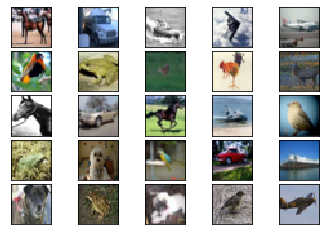

In [122]:
if __name__ == "__main__":
    """show it works"""

    cifar_10_dir = "../../data/CIFAR10/cifar-10-batches-py/"

    train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names = \
        load_cifar_10_data(cifar_10_dir)

    print("Train data: ", train_data.shape)
    print("Train filenames: ", train_filenames.shape)
    print("Train labels: ", train_labels.shape)
    print("Test data: ", test_data.shape)
    print("Test filenames: ", test_filenames.shape)
    print("Test labels: ", test_labels.shape)
    print("Label names: ", label_names.shape)

    # Don't forget that the label_names and filesnames are in binary and need conversion if used.

    # display some random training images in a 25x25 grid
    num_plot = 5
    f, ax = plt.subplots(num_plot, num_plot)
    for m in range(num_plot):
        for n in range(num_plot):
            idx = np.random.randint(0, train_data.shape[0])
            ax[m, n].imshow(train_data[idx])
            ax[m, n].get_xaxis().set_visible(False)
            ax[m, n].get_yaxis().set_visible(False)
    f.subplots_adjust(hspace=0.1)
    f.subplots_adjust(wspace=0)
    plt.show()

Stretch the images for both the training dataset as well as the test dataset out into rows:

In [125]:
training_data_rows = train_data.reshape(train_data.shape[0], 32 * 32 * 3) # train_data becomes 50000 x 3072
test_data_rows = test_data.reshape(test_data.shape[0], 32 * 32 * 3) # test_data becomes 10000 x 3072

Now we can train and evaluate a classifier:

In [142]:
import numpy as np

class NearestNeighbor(object):
    def __init__(self):
        pass

    def train(self, X, y):
        """ X is N x D where each row is an example. Y is 1-dimension of size N """
        # the nearest neighbor classifier simply remembers all the training data
        self.Xtr = X
        self.ytr = y

    def predict(self, X):
        """ X is N x D where each row is an example we wish to predict label for """
        num_test = X.shape[0]
        # lets make sure that the output type matches the input type
        Ypred = np.zeros(num_test, dtype = self.ytr.dtype)

        # loop over all test rows
        for i in range(num_test):
          # find the nearest training image to the i'th test image
          # using the L1 distance (sum of absolute value differences)
          distances = np.sum(np.abs(self.Xtr - X[i,:]), axis = 1)
          min_index = np.argmin(distances) # get the index with smallest distance
          Ypred[i] = self.ytr[min_index] # predict the label of the nearest example

        return Ypred

In [143]:
nn = NearestNeighbor() # create a Nearest Neighbor classifier class

In [134]:
nn.train(training_data_rows, train_labels) # train the classifier on the training images and labels

In [144]:
test_labels_predict = nn.predict(training_data_rows) # predict labels on the test images

AttributeError: 'NearestNeighbor' object has no attribute 'ytr'

In [133]:
# and now print the classification accuracy, which is the average number
# of examples that are correctly predicted (i.e. label matches)
print('accuracy: %f' % ( np.mean(Yte_predict == Yte) ))

NameError: name 'Xte_rows' is not defined

In [11]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [77]:
data = "../../data/CIFAR10/cifar-10-batches-py/"
datalist = os.listdir(data)

In [78]:
for line in datalist:
    print(line)

data_batch_1
readme.html
batches.meta
data_batch_2
data_batch_5
test_batch
data_batch_4
data_batch_3


In [109]:
a = 'btraining batch 1 of 5 b labels'

In [110]:
for i in range(len(a)):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [ ]:
for i in len

In [112]:
training_data = np.array([])

for line in datalist:
    if line[0:4] == 'data':
        path = os.path.join(data,line)
        print("loading... ", path)
        x = unpickle(path)
        print(x, type(x))# , len(x[b'batch_label']), len(x['training batch 1 of 5']), len(x[b'labels']))
        
        
#         x = np.array(list(unpickle(path).keys))
#         print(x.shape)
        
#         training_data = np.append(training_data, x)

loading...  ../../data/CIFAR10/cifar-10-batches-py/data_batch_1
{b'batch_label': b'training batch 1 of 5', b'labels': [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1, 2, 2, 9, 2, 6, 6, 1, 9, 5, 0, 4, 7, 6, 7, 1, 8, 1, 1, 2, 8, 1, 3, 3, 6, 2, 4, 9, 9, 5, 4, 3, 6, 7, 4, 6, 8, 5, 5, 4, 3, 1, 8, 4, 7, 6, 0, 9, 5, 1, 3, 8, 2, 7, 5, 3, 4, 1, 5, 7, 0, 4, 7, 5, 5, 1, 0, 9, 6, 9, 0, 8, 7, 8, 8, 2, 5, 2, 3, 5, 0, 6, 1, 9, 3, 6, 9, 1, 3, 9, 6, 6, 7, 1, 0, 9, 5, 8, 5, 2, 9, 0, 8, 8, 0, 6, 9, 1, 1, 6, 3, 7, 6, 6, 0, 6, 6, 1, 7, 1, 5, 8, 3, 6, 6, 8, 6, 8, 4, 6, 6, 1, 3, 8, 3, 4, 1, 7, 1, 3, 8, 5, 1, 1, 4, 0, 9, 3, 7, 4, 9, 9, 2, 4, 9, 9, 1, 0, 5, 9, 0, 8, 2, 1, 2, 0, 5, 6, 3, 2, 7, 8, 8, 6, 0,

In [87]:
training_data.shape

(5,)

In [67]:
training_data = []

for file in datalist:
    if file[0:4] == 'data':
        path = os.path.join(data,file)
        print("loading... ", path)
        x = unpickle(path)
        x = np.array(x)
        training_data.append(x)
        
training_data = np.stack(training_data)

loading...  ../../data/CIFAR10/cifar-10-batches-py/data_batch_1
loading...  ../../data/CIFAR10/cifar-10-batches-py/data_batch_2
loading...  ../../data/CIFAR10/cifar-10-batches-py/data_batch_5
loading...  ../../data/CIFAR10/cifar-10-batches-py/data_batch_4
loading...  ../../data/CIFAR10/cifar-10-batches-py/data_batch_3


In [69]:
training_data = np.array(training_data)

In [70]:
training_data.shape

(5,)

In [62]:
train_rows = training_data.reshape(training_data.shape[0], 32 * 32 * 3)

ValueError: cannot reshape array of size 5 into shape (5,3072)

In [55]:
train_rows = training_data.reshape(training_data.shape[0], 32 * 32 * 3) # Xtr_rows becomes 50000 x 3072

AttributeError: 'list' object has no attribute 'reshape'

In [32]:


for file in xx:
    if str(file[0:3]) == 'data':
        print(file[0:3])
        x = unpickle(file)
        training_data.append(x)

In [ ]:
Xtr, Ytr, Xte, Yte = load_CIFAR10('data/cifar10/') # a magic function we provide
# flatten out all images to be one-dimensional
Xtr_rows = Xtr.reshape(Xtr.shape[0], 32 * 32 * 3) # Xtr_rows becomes 50000 x 3072
Xte_rows = Xte.reshape(Xte.shape[0], 32 * 32 * 3) # Xte_rows becomes 10000 x 3072